# Data Selection

The data used for our project was selected from several sources including cryptocompare website. The cryptocompare api for example returns following columns:

- open, the price at which the period opened,
- high, the highest price reached during the period,
- low, the lowest price reached during the period,
- close, the price at which the period closed,
- volumefrom, the volume in the base currency that things are traded into,
- volumeto, the volume in the currency that is being traded.

Other sources include:

- EPU_idx: Economic Policy Uncertainty Index
- Google Trends: Google daily searches with one day resolution


Before the step involving the application of machine learning techniques, we are first going to explore the resulting dataset. Knowing that in this project, we explore the use of neural networks combined with semantic analysis to improve price prediction of a cryptocurrency. It is showing that a number of statistical approaches could be used to predict the price in an hour, a day, or a week. We will focuss on a daily prediction. The first step we are going to take is the analysis of the overall trend of the price data. 

In [107]:
#Libraries used in this notebook
from pandas import read_csv
from pandas import set_option
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import numpy
from numpy import concatenate
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from statsmodels.tsa.stattools import adfuller
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot

# plot size
plt.rcParams["figure.figsize"] = (18,9)

In [108]:
def adf(x):
    for c in x.columns[1:]:
        adf_x = adfuller(x[c])
        if adf_x[1] <= 0.05:
            print (c, "--- Stationary")
        else:
            print (c, "--- Non Stationary")

In [109]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rollmean = timeseries.rolling(window=12, center=False).mean()
    rollstd = timeseries.rolling(window=12,  center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rollmean, color='red', label='Rolling Mean')
    std = plt.plot(rollstd, color='black', label = 'Rolling Std')
    #(figsize=(20,10), linewidth=5, fontsize=20)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    

# Data Exploration

The dataset contains several data points about the cryptocurrency bitcoin daily trade.

## Loading the data

In [110]:
fname1 = "btc_all.csv"
df1 = pd.read_csv(fname1)
print(df1.shape)

(730, 11)


In [111]:
# get the data
fname="btc_new_3_24.csv"
df = pd.read_csv(fname)

In [112]:
print(df1.head(10))

   Unnamed: 0            date    trans  volatil  bidask   price     volume  transpm  goog_idx  \
0           0  2/25/2016 0:00 -12655.0   -0.314  -0.036   1.014  6.177e+06  -25.374      -2.0   
1           1  2/26/2016 0:00 -21458.0   -0.093   0.037   8.066  1.461e+08  -42.287      -1.0   
2           2  2/27/2016 0:00  51259.0    0.197   0.014  -2.966 -4.094e+07   31.346      -2.0   
3           3  2/28/2016 0:00  31884.0    0.268   0.065   7.213  2.760e+08  118.520       0.0   
4           4  2/29/2016 0:00  11774.0   -0.097  -0.025  -2.126 -3.762e+08  -24.499       3.0   
5           5   3/1/2016 0:00  -6888.0   -0.147  -0.020  -2.333 -3.597e+06  -11.184      -2.0   
6           6   3/2/2016 0:00 -48554.0    0.055  -0.001 -10.137  7.196e+06   15.333       4.0   
7           7   3/3/2016 0:00 -14167.0   -0.021   0.018  -2.204 -1.395e+06  -54.304      -3.0   
8           8   3/4/2016 0:00  27507.0    0.751   0.050 -15.836  1.863e+07   98.190      -1.0   
9           9   3/5/2016 0:00 

## Overview of the data

In [113]:
#Dimension of the data

In [114]:
# Dimensions of your data
df_shape = df.shape
print(df_shape)

(1826, 8)


Our dataset looks like this:

In [115]:
# Viewing the first 10 rows
df_head10 = df.head(10)
print(df_head10)

       day  epu_idx    price     volume  bidask    tpm  trans  exp_sem
0  3/24/13   126.08   68.288  3.361e+06   0.762  2.204  51335    0.241
1  3/25/13   178.57   73.649  6.917e+06   0.978  2.824  48993    0.202
2  3/26/13   163.29   77.091  5.323e+06   0.931  2.560  49061    0.000
3  3/27/13   177.06   85.257  7.356e+06   1.034  3.199  53207    0.212
4  3/28/13    72.92   90.659  1.477e+07   1.556  5.050  60989    0.202
5  3/29/13    90.71   90.099  8.917e+06   1.125  3.436  62259    0.240
6  3/30/13   115.02   91.499  4.145e+06   1.024  2.069  59196    0.145
7  3/31/13   154.03   92.960  2.547e+06   0.796  1.428  43986    0.000
8   4/1/13   104.12   97.869  1.155e+07   0.860  4.275  52770    0.220
9   4/2/13    86.12  107.408  1.203e+07   0.895  5.492  63276    0.000


#### Data type of each attribute in the dataset

In [116]:
#Data Analysis
print(df.dtypes)

day         object
epu_idx    float64
price      float64
volume     float64
bidask     float64
tpm        float64
trans        int64
exp_sem    float64
dtype: object


We can observe that the column day type is not datetime. Let’s proceed to the conversion.

In [117]:
df.day = pd.to_datetime(df.day)
print(df.dtypes)

day        datetime64[ns]
epu_idx           float64
price             float64
volume            float64
bidask            float64
tpm               float64
trans               int64
exp_sem           float64
dtype: object


Now, let’s create the index on the day.

In [118]:
df.set_index('day', inplace=True)
print(df.head(5))

            epu_idx   price     volume  bidask    tpm  trans  exp_sem
day                                                                  
2013-03-24   126.08  68.288  3.361e+06   0.762  2.204  51335    0.241
2013-03-25   178.57  73.649  6.917e+06   0.978  2.824  48993    0.202
2013-03-26   163.29  77.091  5.323e+06   0.931  2.560  49061    0.000
2013-03-27   177.06  85.257  7.356e+06   1.034  3.199  53207    0.212
2013-03-28    72.92  90.659  1.477e+07   1.556  5.050  60989    0.202


### Basic statistics

In [119]:
# Statistical Summary
set_option('display.width', 100)
set_option('precision', 3)
df_description = df.describe()
print(df_description)

        epu_idx      price     volume    bidask       tpm       trans   exp_sem
count  1826.000   1826.000  1.826e+03  1826.000  1826.000    1826.000  1826.000
mean     84.022   1589.946  1.729e+08     0.685    10.753  159656.232     0.130
std      46.585   3073.814  4.558e+08     0.628    13.572   94999.323     0.169
min       3.320     66.795  9.713e+05     0.116     1.039   30356.000    -0.937
25%      53.562    268.924  1.468e+07     0.350     4.254   69419.000     0.048
50%      74.545    481.286  2.617e+07     0.491     5.909  136347.500     0.125
75%     102.752    896.842  6.703e+07     0.784    10.924  235311.500     0.209
max     586.550  19389.505  5.458e+09     5.061   144.759  490644.000     0.888


The price is showing a minimum of 66.795, a maximum of 19389.505 with a mean at 1589.946. Let's look further at the price information.

Correlations between variables were calculated and plotted. 

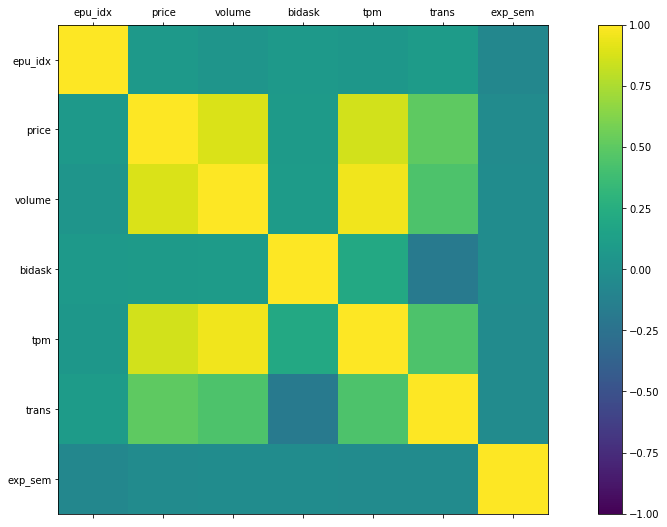

In [120]:
names = ('epu_idx', 'price', 'volume', 'bidask', 'tpm', 'trans', 'exp_sem') 
correlations = df.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

### Visual Overview of the raw data

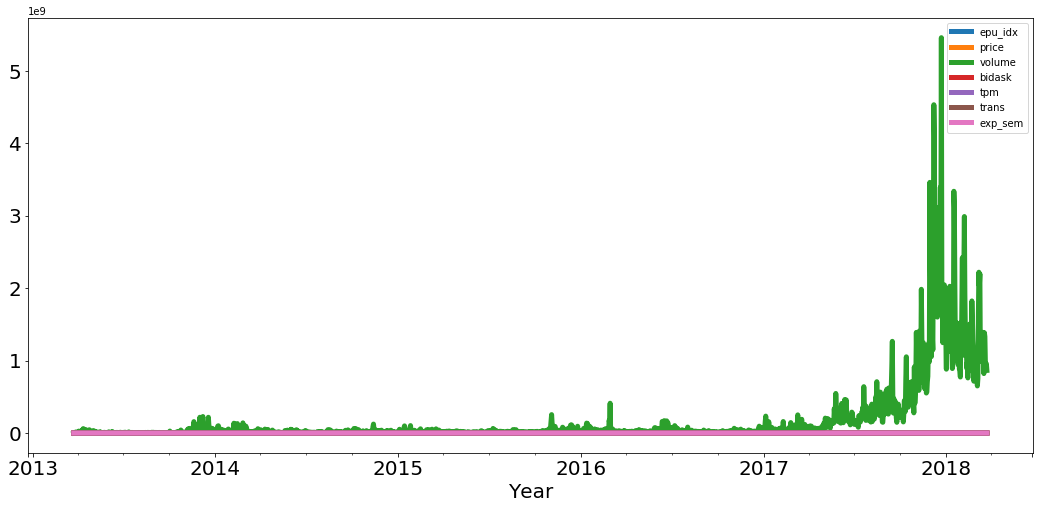

In [121]:
df.plot(figsize=(18,8), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

Time series forecasts usually require stationarity. This means the model will have constant mean, variance, and auto-correlation over time. A quick look at the chart above shows that some attribute are non stationary. Lets perform another test to confirm. We will be using the adfuller() function in the Statsmodels library for this purpose.

In [122]:
adf(df)

price --- Non Stationary
volume --- Non Stationary
bidask --- Stationary
tpm --- Non Stationary
trans --- Non Stationary
exp_sem --- Stationary


Some attributes in our dataset like price, volume, tpm, and trans are non-stationary: the mean and the variance of those observations change over time. It will be difficult to model the dataset as it is. 

We will continue by testing further for stationarity.

### Testing for Stationarity

In this section, we will outputs the result of a statistical significance test of whether the 1-lag
differenced series is stationary. Specifically, the augmented Dickey-Fuller test.

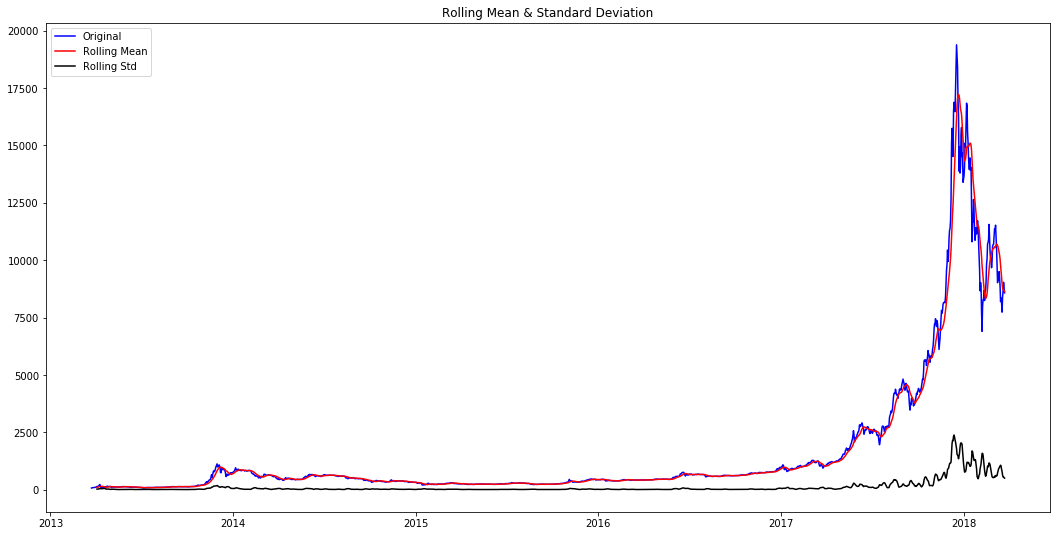

Results of Dickey-Fuller Test:
Test Statistic                   -1.700
p-value                           0.431
#Lags Used                       25.000
Number of Observations Used    1800.000
Critical Value (1%)              -3.434
Critical Value (5%)              -2.863
Critical Value (10%)             -2.568
dtype: float64


In [123]:
test_stationarity(df['price'])

The results showthat the test statistic value -1.700 is larger than the critical value at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary.

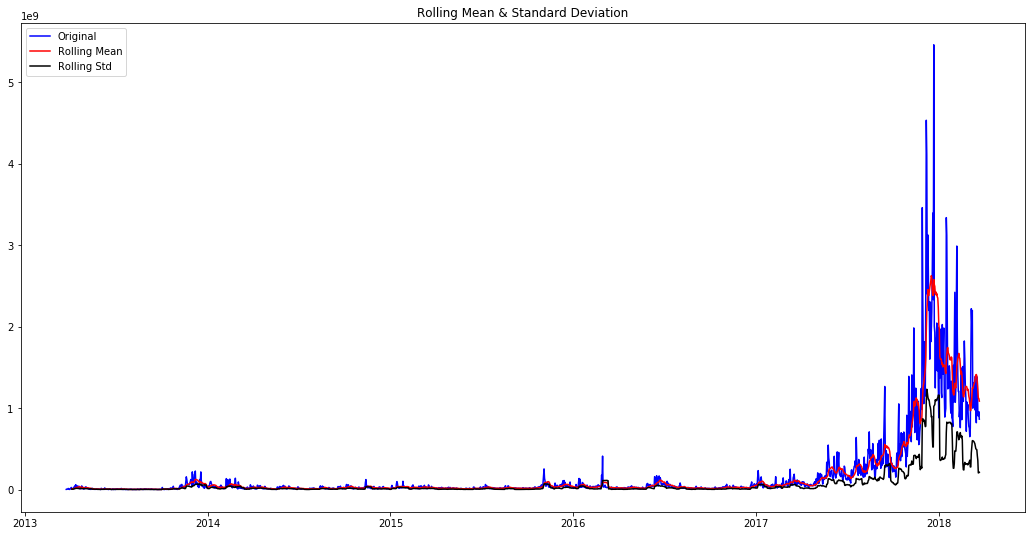

Results of Dickey-Fuller Test:
Test Statistic                   -1.636
p-value                           0.464
#Lags Used                       24.000
Number of Observations Used    1801.000
Critical Value (1%)              -3.434
Critical Value (5%)              -2.863
Critical Value (10%)             -2.568
dtype: float64


In [124]:
test_stationarity(df['volume'])

The results showthat the test statistic value -1.636 is larger than the critical value at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary.

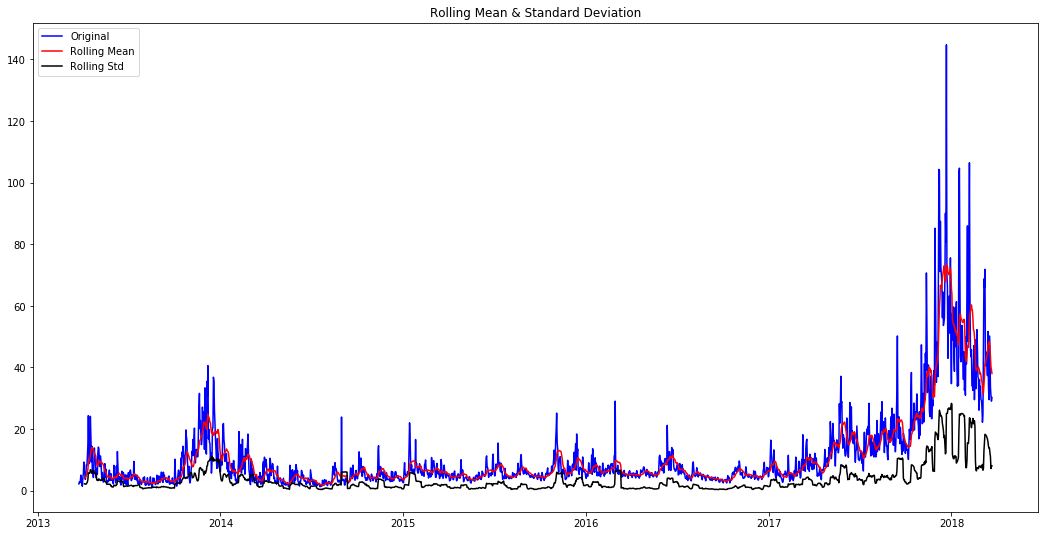

Results of Dickey-Fuller Test:
Test Statistic                   -1.403
p-value                           0.581
#Lags Used                       24.000
Number of Observations Used    1801.000
Critical Value (1%)              -3.434
Critical Value (5%)              -2.863
Critical Value (10%)             -2.568
dtype: float64


In [125]:
test_stationarity(df['tpm'])

The results showthat the test statistic value -1.403 is larger than the critical value at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary.

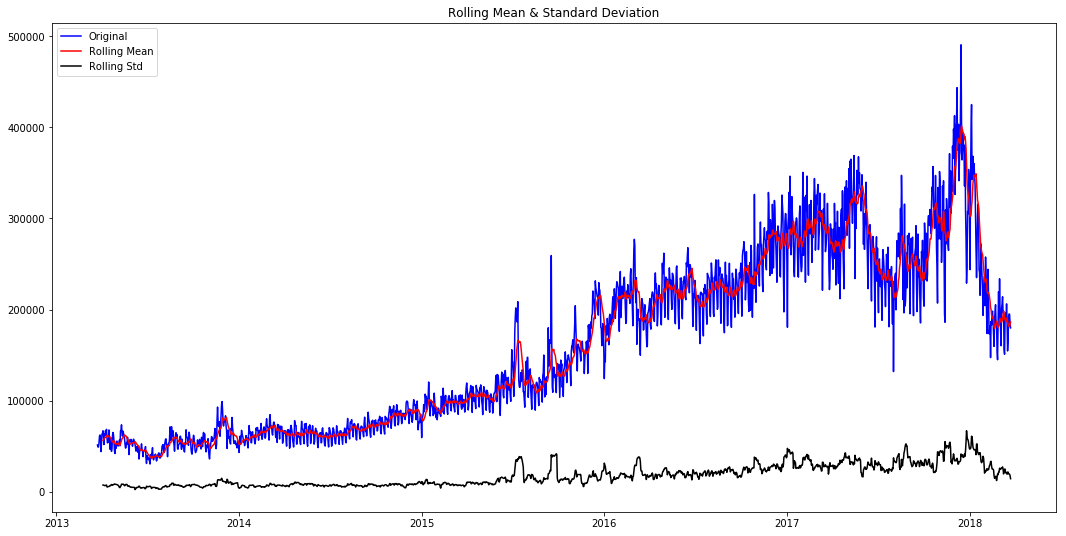

Results of Dickey-Fuller Test:
Test Statistic                   -1.552
p-value                           0.508
#Lags Used                       24.000
Number of Observations Used    1801.000
Critical Value (1%)              -3.434
Critical Value (5%)              -2.863
Critical Value (10%)             -2.568
dtype: float64


In [126]:
test_stationarity(df['trans'])

The results showthat the test statistic value -1.552 is larger than the critical value at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary.

The next time series data analysis method that we are going to use is Data decomposition.

### Data decomposition

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

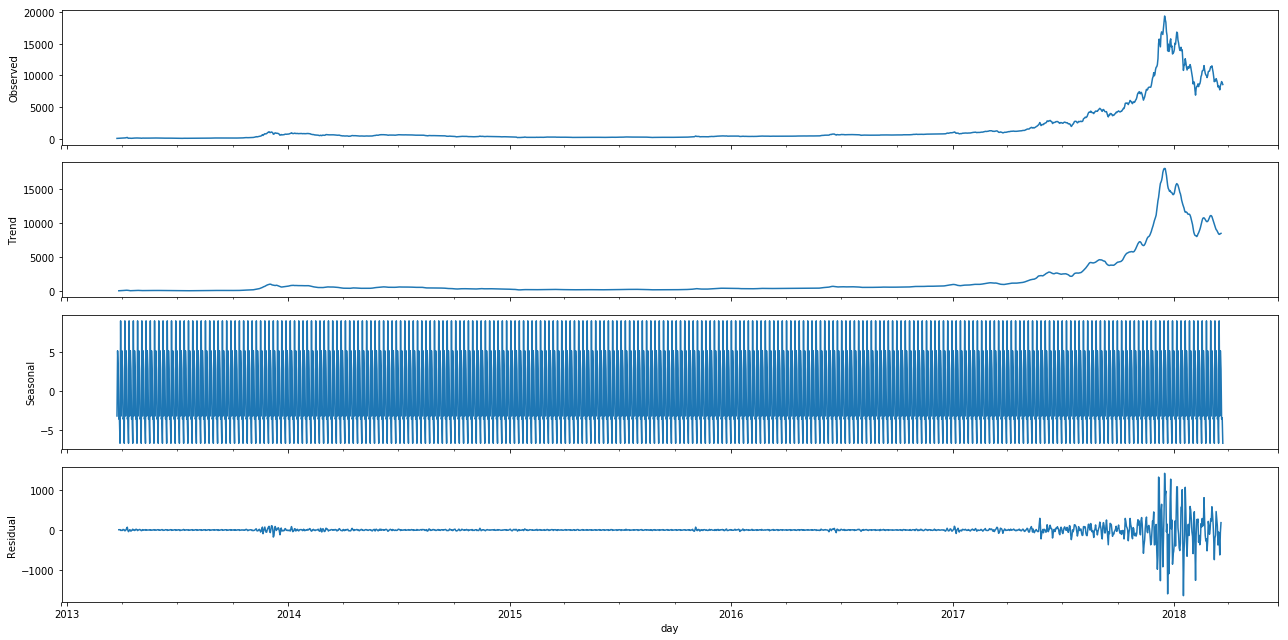

In [128]:

decomposition = sm.tsa.seasonal_decompose(df[['price']], model='additive')
fig = decomposition.plot()
plt.show()

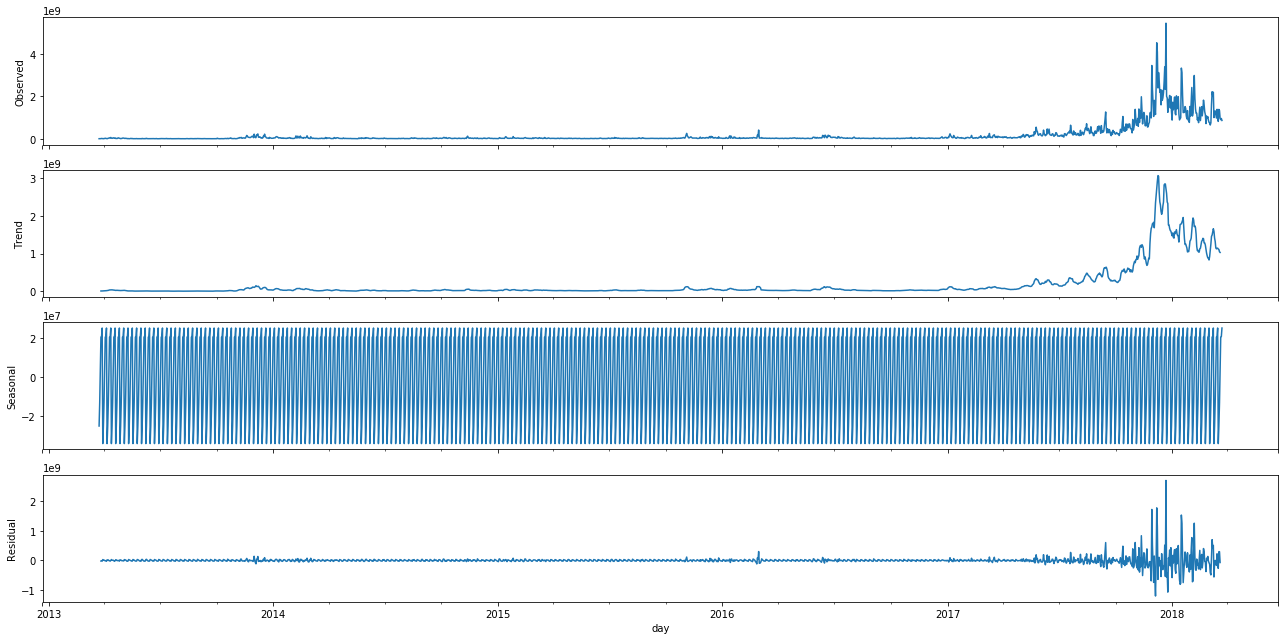

In [130]:
decomposition = sm.tsa.seasonal_decompose(df[['volume']], model='additive')
fig = decomposition.plot()
plt.show()

Data Transformation for Stationarity

In a different code, we will use differencing to make the data stationary for modeling.